###1. Download and Install Necessary Packages

In [ ]:
!pip install pandas
!pip install trl==0.14.0
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip show trl

Name: trl
Version: 0.14.0
Summary: Train transformer language models with reinforcement learning.
Home-page: https://github.com/huggingface/trl
Author: Leandro von Werra
Author-email: leandro.vonwerra@gmail.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, datasets, rich, transformers
Required-by: 


In [ ]:
import io
import os
import random
import pandas as pd
import numpy as np
from operator import itemgetter
import torch
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import AutoModelForSequenceClassification,AutoTokenizer,TrainingArguments
from trl import RewardTrainer, RewardConfig
from google.colab import files, drive
from transformers import TrainerCallback

###2. Dataset and Model Setup

In [ ]:
drive.mount('/content/drive')
drive_save_path = "/content/drive/My Drive/reward_model"
os.makedirs(drive_save_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Load Dataset
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['pair_gsm8k_v2 (2).csv']))
prepared_dataset = Dataset.from_pandas(df)
print(df)

Saving pair_gsm8k_v2.csv to pair_gsm8k_v2 (2).csv
                                            instruction  \
0     Natalia sold clips to 48 of her friends in Apr...   
1     Weng earns $12 an hour for babysitting. Yester...   
2     Betty is saving money for a new wallet which c...   
3     Julie is reading a 120-page book. Yesterday, s...   
4     James writes a 3-page letter to 2 different fr...   
...                                                 ...   
8784  John had a son James when he was 19.  James is...   
8785  There are some oranges in a basket. Ana spends...   
8786  Mark's car breaks down and he needs to get a n...   
8787  Farmer Brown has 20 animals on his farm, all e...   
8788  Henry and 3 of his friends order 7 pizzas for ...   

                                        chosen_response  \
0     <plan_generator>Calculate the number of clips ...   
1     <plan_generator>Calculate Weng's earnings by f...   
2     <plan_generator>First, find out how much money...   
3    

In [ ]:
#Selecting base model whch needs to train for reward modeling.
model_name = "distilroberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

def formatting_func(examples):
    kwargs = {"padding": "max_length", "truncation": True, "max_length": 512, "return_tensors": "pt"}

    prompt_plus_chosen_response = examples["instruction"] + "\n" + examples["chosen_response"]
    prompt_plus_rejected_response = examples["instruction"] + "\n" + examples["rejected_response"]
    tokens_chosen = tokenizer.encode_plus(prompt_plus_chosen_response, **kwargs)
    tokens_rejected = tokenizer.encode_plus(prompt_plus_rejected_response, **kwargs)

    return {
        "input_ids_chosen": tokens_chosen["input_ids"][0], "attention_mask_chosen": tokens_chosen["attention_mask"][0],
        "input_ids_rejected": tokens_rejected["input_ids"][0], "attention_mask_rejected": tokens_rejected["attention_mask"][0]
    }

formatted_dataset = prepared_dataset.map(formatting_func)
formatted_dataset = formatted_dataset.train_test_split()

formatted_dataset

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/8789 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'chosen_response', 'rejected_response', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 6591
    })
    test: Dataset({
        features: ['instruction', 'chosen_response', 'rejected_response', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 2198
    })
})

In [ ]:
logit_history = []  # Storing logits over time

class LogitTrackingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        """Callback to log logits during training"""
        if logs is not None and "logits" in logs:
            logit_history.append(logs["logits"])

###3. Training the reward Model

In [ ]:
# Hyperparametr Tuning
training_args = RewardConfig(
    output_dir="./reward_model",
    per_device_train_batch_size=32,
    eval_strategy="steps",
    logging_steps=1,
    num_train_epochs = 0.5,
    save_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    report_to=None,
)

trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    callbacks=[LogitTrackingCallback()],
)

trainer.train()
trainer.save_model(drive_save_path)
tokenizer.save_pretrained(drive_save_path)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vimukthi-20210942 (vimukthi-20210942-robert-gordon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
1,0.697700,0.697352,0.042311
2,0.697000,0.693379,0.473612
3,0.693500,0.686557,0.996815
4,0.686800,0.677272,1.000000
5,0.677500,0.666419,1.000000
6,0.666400,0.651401,1.000000
7,0.651600,0.630133,1.000000
8,0.631700,0.601217,1.000000
9,0.604000,0.564144,1.000000
10,0.564500,0.519092,1.000000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.4969, 0.5031] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.4982, 0.5018] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.4988, 0.5012] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.4993, 0.5007] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5011, 0.4989] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5027, 0.4973] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5053, 0.4947] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5062, 0.4938] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5122, 0.4878] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.512, 0.488]   │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5189, 0.4811] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5178, 0.4822] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5309, 0.4691] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5237, 0.4763] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5458, 0.4542] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5366, 0.4634] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5717, 0.4283] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.555, 0.445]   │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.5989, 0.4011] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.5779, 0.4221] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.6321, 0.3679] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.6049, 0.3951] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.6747, 0.3253] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.6368, 0.3632] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.7154, 0.2846] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.6753, 0.3247] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.7596, 0.2404] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.713, 0.287]   │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.8126, 0.1874] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.7661, 0.2339] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.8232, 0.1768] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.8112, 0.1888] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.8743, 0.1257] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.8358, 0.1642] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9035, 0.0965] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.881, 0.119]   │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9197, 0.0803] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.8713, 0.1287] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9269, 0.0731] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9059, 0.0941] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9252, 0.0748] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9258, 0.0742] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9362, 0.0638] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9318, 0.0682] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9301, 0.0699] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9261, 0.0739] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9282, 0.0718] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9209, 0.0791] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.9465, 0.0535] │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.9334, 0.0666] │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <s>Krystiana owns an apartment building. The  │ <s>Krystiana owns an apartment building. The │ [0.942, 0.058]   │
│ rooms on the first floor cost $15 per month   │ rooms on the first floor cost $15 per month  │                  │
│ and the rooms on the 2nd floor cost $20 per   │ and the rooms on the 2nd floor cost $20 per  │                  │
│ month. The rooms on the third floor cost      │ month. The rooms on the third floor cost     │                  │
│ twice as much as the rooms on the first       │ twice as much as the rooms on the first      │                  │
│ floor, but only two rooms are occupied. If    │ floor, but only two rooms are occupied. If   │                  │
│ each floor has 3 rooms, how much does         │ each floor has 3 rooms, how much does        │                  │
│ Krystiana earn every month?                   │ Krystiana earn every month?                  │                  │
│ <plan_generator>1. Calculate the monthly      │ Krystiana earns $15 x 3 = $<<15*3=45>>45 for │                  │
│ earnings from the first floor. 2. Calculate   │ the rooms on the first floor every month.    │                  │
│ the monthly earnings from the second floor.   │ She earns $20 x 3 = $<<20*3=60>>60 for the   │                  │
│ 3. Calculate the monthly earnings from the    │ rooms on the second floor every month.       │                  │
│ third floor, considering only the occupied    │ And the cost for each room on the third      │                  │
│ rooms. 4. Sum all the earnings from each      │ floor is $15 x 2 = $<<15*2=30>>30.           │                  │
│ floor to get the total                        │ So, the total amount she earns for the rooms │                  │
│ earnings.</plan_generator><projector>If I     │ on the third floor is $30 x 2 =              │                  │
│ execute this plan, I will determine the       │ $<<30*2=60>>60 every month.                  │                  │
│ individual earnings for each floor and find   │ Therefore, the total amount she earns from   │                  │
│ the total monthly income, which will give me  │ the apartment building is $60 + $60 + $45 =  │                  │
│ the correct answer.</projector></s>           │ $<<60+60+45=165>>165.                        │                  │
│                                               │ #### 165</s>                                 │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│ <s>Last month, Tasha made $80 from selling    │ <s>Last month, Tasha made $80 from selling   │ [0.933, 0.067]   │
│ lemonade and mowing lawns. The first week,    │ lemonade and mowing lawns. The first week,   │                  │
│ she mowed Kamala's lawn thrice as many times  │ she mowed Kamala's lawn thrice as many times │                  │
│ as she did Joe's. The following week, she     │ as she did Joe's. The following week, she    │                  │
│ mowed Alba's lawn five times as she did       │ mowed Alba's lawn five times as she did      │                  │
│ Joe's. If Joe paid Tasha $6 for her work, how │ Joe's. If Joe paid Tasha $6 for her work,    │                  │
│ much did she make from lemonade sales?        │ how much did she make from lemonade sales?   │                  │
│ <plan_generator>First, we calculate Tasha's   │ At Kamala's Tasha made three times what she  │                  │
│ earnings from mowing lawns. We know Joe paid  │ made mowing Joe's lawn, which gives 3 * 6 =  │                  │
│ her $6, and we will denote the number of      │ <<3*6=

('/content/drive/My Drive/reward_model_v3/tokenizer_config.json',
 '/content/drive/My Drive/reward_model_v3/special_tokens_map.json',
 '/content/drive/My Drive/reward_model_v3/vocab.json',
 '/content/drive/My Drive/reward_model_v3/merges.txt',
 '/content/drive/My Drive/reward_model_v3/added_tokens.json',
 '/content/drive/My Drive/reward_model_v3/tokenizer.json')

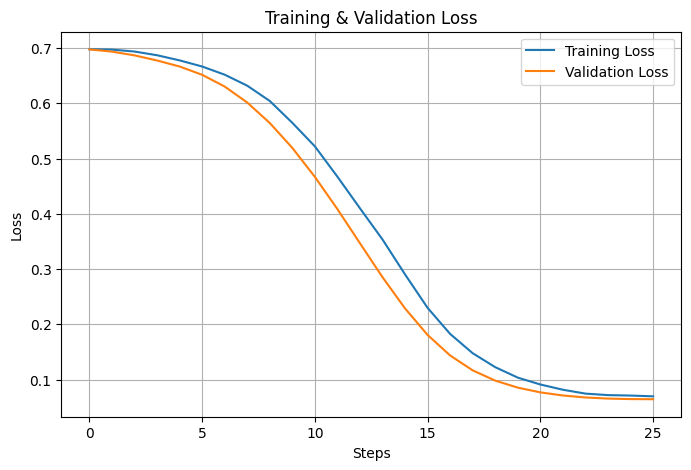

In [ ]:
# Extracting loss values
logs = trainer.state.log_history
train_losses = [log["loss"] for log in logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

steps = list(range(len(train_losses)))

# Plotting Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Training Loss")
plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

###4. Manual Testing for Reward Model

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Loading the trained reward model
model_path = "/content/drive/My Drive/reward_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def compute_hessian(model, inputs):
    """ Computes the Hessian approximation for Laplace posterior calculation. """
    original_device = next(model.parameters()).device  # Save original device
    model = model.to("cpu")  # Move model to CPU
    inputs = {k: v.to("cpu") for k, v in inputs.items()}  # Move inputs to CPU

    outputs = model(**inputs).logits
    loss = outputs.sum()

    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    hessian_diag = [g**2 for g in grads]  # Compute diagonal Hessian

    model.to(original_device)  # Move model back to original device

    # Move Hessian back to GPU
    hessian_diag = [h.to(original_device) for h in hessian_diag]
    return hessian_diag, grads

def compute_uncertainty(model, inputs, hessian_inv, hessian_grads):
    """ Computes uncertainty for a given input using Hessian approximation. """
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    hessian_inv = [h.to(device) for h in hessian_inv]

    # Computing uncertainty as gradient projection through Hessian inverse
    uncertainty = sum((g * h * g).sum() for g, h in zip(hessian_grads, hessian_inv))
    return uncertainty.item()

def test_reward_model_with_posterior(instruction, response, k=0.5):
    """ Encodes input text, runs inference, and applies Bayesian posterior adjustment. """

    input_text = instruction + "\n" + response
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Computing reward score
    with torch.no_grad():
        outputs = model(**inputs)
    reward_score = outputs.logits.item()

    # Computing Hessian approximation (post-training)
    hessian_matrix, hessian_grads = compute_hessian(model, inputs)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Computing uncertainty from Hessian
    ts_uncertainty = compute_uncertainty(model, inputs, hessian_matrix, hessian_grads)

    # Applying Thompson Sampling
    sampled_reward = np.random.normal(reward_score, np.sqrt(ts_uncertainty))

    return reward_score, ts_uncertainty, sampled_reward

# dry run
instruction = "Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?"
response_1 = """
<goal_detector>We need to find out how many slices of pizza each person can have if 7 pizzas are shared equally among Henry and his 3 friends.</goal_detector>
<plan_generator>First, calculate the total number of slices of pizza by multiplying the number of pizzas (7) by the number of slices per pizza (8). Then, determine how many people there are by adding Henry and his 3 friends (4 people total). Finally, divide the total number of slices by the number of people to find out how many slices each person gets.</plan_generator>
<projector>If I execute this plan, I will first calculate the total number of slices: 7 pizzas * 8 slices/pizza = 56 slices. Then, with 4 people sharing, I will divide 56 slices by 4, which will give 14 slices per person. This should give the correct answer.</projector>
<executer>The answer is that each person can have 14 slices of pizza. </executer>
"""

response_2 = """
There are 7*8=<<7*8=56>>56 slices in total.
There are 1+3=<<1+3=4>>4 people in total.
They can each have 56/4=<<56/4=14>>14 slices.
#### 14
"""

score_1, uncertainty_1, adj_score_1 = test_reward_model_with_posterior(instruction, response_1)
score_2, uncertainty_2, adj_score_2 = test_reward_model_with_posterior(instruction, response_2)

print(f"Response 1 - Raw Reward: {score_1}, Uncertainty: {uncertainty_1}, Adjusted Reward: {adj_score_1}")
print(f"Response 2 - Raw Reward: {score_2}, Uncertainty: {uncertainty_2}, Adjusted Reward: {adj_score_2}")

Response 1 - Raw Reward: 6.264081001281738, Uncertainty: 100.28486633300781, Adjusted Reward: 9.851141475432385
Response 2 - Raw Reward: -5.53516960144043, Uncertainty: 89.80696105957031, Adjusted Reward: -4.036420850677495


In [ ]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Loading the trained reward model
model_path = "/content/drive/My Drive/reward_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

uncertainty_cache = {}
model.train()
device = torch.device("cuda")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
def compute_fisher_information(model, inputs):
    """ Computes Fisher Information and returns both Fisher Approximation and gradients. """
    # ✅ Forward pass
    outputs = model(**inputs).logits
    loss = outputs.mean()

    # Computing first-order gradients only ONCE
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Computing Fisher Information
    fisher_diag = [g**2 + 1e-6 for g in grads]  # Adding small noise for stability

    return fisher_diag, grads

def compute_uncertainty(model, inputs, fisher_diag, grads):
    """ Computes uncertainty using Fisher Information, but reuses gradients from Fisher computation. """
    inputs_key = tuple(inputs["input_ids"].cpu().numpy().flatten())

    if inputs_key in uncertainty_cache:
        return uncertainty_cache[inputs_key]  # Return precomputed uncertainty

    uncertainty = sum((g * f * g).sum() for g, f in zip(grads, fisher_diag))

    uncertainty_cache[inputs_key] = uncertainty.item()
    return uncertainty.item()

def test_reward_model_with_posterior(instruction, response, k=0.5):
    """ Encodes input text, runs inference, and applies Bayesian posterior adjustment using Fisher Approximation. """

    input_text = instruction + "\n" + response
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Computing reward score
    with torch.no_grad():
        outputs = model(**inputs)
    reward_score = outputs.logits.item()

    # Computing Fisher Information approximation
    fisher_matrix, fisher_grads = compute_fisher_information(model, inputs)

    # Computing cached uncertainty from Fisher Information using precomputed gradients
    ts_uncertainty = compute_uncertainty(model, inputs, fisher_matrix, fisher_grads)

    # Preventing exploding uncertainties
    safe_uncertainty = min(max(ts_uncertainty, 1e-6), 10.0)

    # Applying Thompson Sampling
    std_dev = min(np.sqrt(safe_uncertainty), 5.0)
    sampled_reward = float(np.random.normal(reward_score, std_dev))

    print("\n==============================================")
    print(f"🔹 Instruction: {instruction}")
    print(f"🔹 Response: {response}")
    print(f"🎯 Raw Reward: {reward_score:.5f} | 🎲 Uncertainty: {ts_uncertainty:.5f} | 🏆 Sampled Reward: {sampled_reward:.5f}")
    print("==============================================\n")

    return reward_score, ts_uncertainty, sampled_reward

# Example Inference with Posterior Calculation
instruction = "Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?"
response_1 = """
<goal_detector>We need to find out how many slices of pizza each person can have if 7 pizzas are shared equally among Henry and his 3 friends.</goal_detector>
<plan_generator>First, calculate the total number of slices of pizza by multiplying the number of pizzas (7) by the number of slices per pizza (8). Then, determine how many people there are by adding Henry and his 3 friends (4 people total). Finally, divide the total number of slices by the number of people to find out how many slices each person gets.</plan_generator>
<projector>If I execute this plan, I will first calculate the total number of slices: 7 pizzas * 8 slices/pizza = 56 slices. Then, with 4 people sharing, I will divide 56 slices by 4, which will give 14 slices per person. This should give the correct answer.</projector>
<executer>The answer is that each person can have 14 slices of pizza. </executer>
"""

response_2 = """
There are 7*8=<<7*8=56>>56 slices in total.
There are 1+3=<<1+3=4>>4 people in total.
They can each have 56/4=<<56/4=14>>14 slices.
#### 14
"""

score_1, uncertainty_1, adj_score_1 = test_reward_model_with_posterior(instruction, response_1)
score_2, uncertainty_2, adj_score_2 = test_reward_model_with_posterior(instruction, response_2)

print(f"Response 1 - Raw Reward: {score_1}, Uncertainty: {uncertainty_1}, Adjusted Reward: {adj_score_1}")
print(f"Response 2 - Raw Reward: {score_2}, Uncertainty: {uncertainty_2}, Adjusted Reward: {adj_score_2}")


🔹 Instruction: Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?
🔹 Response: 
<goal_detector>We need to find out how many slices of pizza each person can have if 7 pizzas are shared equally among Henry and his 3 friends.</goal_detector>
<plan_generator>First, calculate the total number of slices of pizza by multiplying the number of pizzas (7) by the number of slices per pizza (8). Then, determine how many people there are by adding Henry and his 3 friends (4 people total). Finally, divide the total number of slices by the number of people to find out how many slices each person gets.</plan_generator>
<projector>If I execute this plan, I will first calculate the total number of slices: 7 pizzas * 8 slices/pizza = 56 slices. Then, with 4 people sharing, I will divide 56 slices by 4, which will give 14 slices per person. This should give the correct answe

In [ ]:
import torch
import numpy as np
from typing import List, Dict, Union, Any

class FisherRewardFunction:
    def __init__(self, model, tokenizer, device="cuda", k=0.5):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.k = k
        self.uncertainty_cache = {}

    def compute_fisher_information(self, batch_inputs: Dict[str, torch.Tensor]):
        """Computes Fisher Information for a batch of inputs."""
        outputs = self.model(**batch_inputs).logits
        loss = outputs.mean()

        grads = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
        fisher_diag = [g**2 + 1e-6 for g in grads]

        return fisher_diag, grads

    def compute_uncertainty(self, batch_inputs: Dict[str, torch.Tensor],
                          fisher_diag: List[torch.Tensor],
                          grads: List[torch.Tensor]) -> List[float]:
        """Computes uncertainty for each item in the batch."""
        batch_size = batch_inputs["input_ids"].size(0)

        # Creating cache keys for batch
        input_keys = [tuple(ids.cpu().numpy().flatten())
                     for ids in batch_inputs["input_ids"]]

        # Checking cache
        uncertainties = []
        uncached_indices = []

        for idx, key in enumerate(input_keys):
            if key in self.uncertainty_cache:
                uncertainties.append(self.uncertainty_cache[key])
            else:
                uncertainties.append(None)
                uncached_indices.append(idx)

        if uncached_indices:
            # Computing batch uncertainty
            batch_uncertainty = sum((g * f * g).sum()
                                  for g, f in zip(grads, fisher_diag))
            individual_uncertainty = batch_uncertainty.item() / batch_size

            # Updating cache and uncertainties list
            for idx in uncached_indices:
                self.uncertainty_cache[input_keys[idx]] = individual_uncertainty
                uncertainties[idx] = individual_uncertainty

        return uncertainties

    def __call__(self, prompts: Union[List[str], List[Dict]],
                 completions: Union[List[str], List[Dict]],
                 **kwargs: Any) -> List[float]:
        """
        Custom reward function compatible with GRPOTrainer.

        Args:
            prompts: List of prompts (strings or message dicts)
            completions: List of completions (strings or message dicts)
            **kwargs: Additional dataset columns

        Returns:
            List of reward scores for each completion
        """
        # Handling both standard and conversational formats
        if isinstance(prompts[0], dict):
            # Conversational format
            input_texts = [f"{p[-1]['content']}\n{c[0]['content']}"
                         for p, c in zip(prompts, completions)]
        else:
            # Standard format
            input_texts = [f"{p}\n{c}" for p, c in zip(prompts, completions)]

        # Tokenize inputs
        batch_inputs = self.tokenizer(
            input_texts,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        )
        batch_inputs = {k: v.to(self.device) for k, v in batch_inputs.items()}

        # Get base reward scores
        with torch.no_grad():
            outputs = self.model(**batch_inputs)
        reward_scores = outputs.logits.cpu().numpy().flatten()

        # Computing Fisher Information and uncertainties
        fisher_matrix, fisher_grads = self.compute_fisher_information(batch_inputs)
        uncertainties = self.compute_uncertainty(batch_inputs, fisher_matrix, fisher_grads)

        # Applying Thompson Sampling
        final_rewards = []
        for reward_score, uncertainty in zip(reward_scores, uncertainties):
            # Applying safety bounds
            safe_uncertainty = min(max(uncertainty, 1e-6), 10.0)
            std_dev = min(np.sqrt(safe_uncertainty), 5.0)

            # Sampling from posterior
            sampled_reward = float(np.random.normal(reward_score, std_dev))
            final_rewards.append(sampled_reward)

        return final_rewards